In [5]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# import chemO_funcs #import o2sat
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
# %run ./chemO_funcs.py

# Combine GFDL data from past present and future

In [2]:
ddpast = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_1850_2000_means.nc')
ddpresent = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_1995_2015.nc')
ddfuture = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4future_2015_2035.nc')
ddfuture2 = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4_2035_2060.nc')

## present data
### Detrend

In [3]:
ds = ddpresent

In [4]:
ds['fCO2_detrended'] = (ds['fCO2'] -  1.89 * (ds['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['ph_detrended'] = (ds['phos'] + 0.0018 * (ds['phos'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['OmegaAr_detrended'] = (ds['OmegaAr'] + 0.0078 * (ds['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, time: 240)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
  * time               (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds        (time) object dask.array<chunksize=(240,), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
Data variables:
    sos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    dissicos           (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    phos               (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    tos                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    talkos             (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    sigma0             (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2               (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr            (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fCO2_detrended     (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ph_detrended       (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    OmegaAr_detrended  (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

### take an annual mean

In [5]:
ddpresent_ann = ds.groupby('time.year').mean(dim="time")
ddpresent_ann

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, year: 20)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
  * year               (year) int64 1995 1996 1997 1998 ... 2011 2012 2013 2014
Data variables:
    sos                (year, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    dissicos           (year, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    phos               (year, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    tos                (year, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    talkos             (year, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    sigma0             (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    fCO2               (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    OmegaAr            (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    fCO2_detrended     (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ph_detrended       (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    OmegaAr_detrended  (year, y, x) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

## future data
### detrend

In [8]:
ds = ddfuture
ds2 = ddfuture2

In [9]:
ds['fCO2_detrended'] = (ds['fCO2'] -  1.89 * (ds['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['ph_detrended'] = (ds['phos'] + 0.0018 * (ds['phos'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['OmegaAr_detrended'] = (ds['OmegaAr'] + 0.0078 * (ds['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])

ds2['fCO2_detrended'] = (ds2['fCO2'] -  1.89 * (ds2['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds2['talkos'])
ds2['ph_detrended'] = (ds2['phos'] + 0.0018 * (ds2['phos'].time.dt.year - 2000)) * xr.ones_like(ds2['talkos'])
ds2['OmegaAr_detrended'] = (ds2['OmegaAr'] + 0.0078 * (ds2['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds2['talkos'])

In [10]:
ddfuture_ann = ds.groupby('time.year').mean(dim="time")
ddfuture_ann2 = ds2.groupby('time.year').mean(dim="time")
ddfuture_ann2.year

<xarray.DataArray 'year' (year: 25)>
array([2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059])
Coordinates:
    member_id       object ...
    dcpp_init_year  float64 ...
  * year            (year) int64 2035 2036 2037 2038 ... 2056 2057 2058 2059

## Create dataset with time dimensions of 
```python
array([1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950,
       1960, 1970, 1980, 1990, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034])
```
Where years prior to 1995 indicate decadal means

## Fill total GFDL dataframe
coords are lat, lon, and time

In [11]:
dd = xr.Dataset()
T = np.concatenate((np.arange(1850,2000,10), np.arange(1995,2035,1)))
dd = dd.assign_coords({'t': T})
dat = np.zeros((len(dd.t)))
dat[:] = np.nan
dd['fCO2'] = xr.Variable(dims = ['t'], data = dat)
dd['OmegaAr'] = xr.Variable(dims = ['t'], data = dat)
dd['ph'] = xr.Variable(dims = ['t'], data = dat)
var = 'fCO2'
for i in T:
    var = 'fCO2'
    if i < 1995:
        dd[var] = xr.where(dd['t'] == i, ddpast[var].sel(t = i), dd[var])
    elif i < 2015:
        dd[var] = xr.where(dd['t'] == i, ddpresent_ann['fCO2_detrended'].sel(year = i), dd[var]) 
    elif i < 2035:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann['fCO2_detrended'].sel(year = i), dd[var])
    elif i < 2060:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann2['fCO2_detrended'].sel(year = i), dd[var])
    var = 'OmegaAr'
    if i < 1995:
        dd[var] = xr.where(dd['t'] == i, ddpast[var].sel(t = i), dd[var])
    elif i < 2015:
        dd[var] = xr.where(dd['t'] == i, ddpresent_ann[var + '_detrended'].sel(year = i), dd[var]) 
    elif i < 2035:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann[var + '_detrended'].sel(year = i), dd[var])
    elif i < 2060:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann2[var + '_detrended'].sel(year = i), dd[var])
    var = 'ph'
    if i < 1995:
        dd[var] = xr.where(dd['t'] == i, ddpast['ph'].sel(t = i), dd[var])
    elif i < 2015:
        dd[var] = xr.where(dd['t'] == i, ddpresent_ann['ph_detrended'].sel(year = i), dd[var]) 
    elif i < 2035:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann['ph_detrended'].sel(year = i), dd[var])
    elif i < 2060:
        dd[var] = xr.where(dd['t'] == i, ddfuture_ann2['ph_detrended'].sel(year = i), dd[var])



In [12]:
dd

<xarray.Dataset>
Dimensions:         (t: 55, y: 180, x: 360)
Coordinates:
  * t               (t) int64 1850 1860 1870 1880 1890 ... 2031 2032 2033 2034
  * y               (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x               (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat_bounds      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lon_bounds      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon             (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat             (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies   (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies   (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id       object ...
    dcpp_init_year  float64 ...
    year            int64 1995
Data variables:
    fCO2            (t, y, x) float64 dask.array<chunksize=(55, 180, 360), meta=np.ndarray>
    OmegaAr         (t, y, x) float64 dask.array<chunksize=(55, 180, 360), meta=np.ndarray>
    ph              (t, y, x) float64 dask.array<chunksize=(55, 180, 360), meta=np.ndarray>

## Save GFDL data

In [13]:
dd = dd.to_netcdf('/Users/akbaskind/Desktop/YoE/GFDLESM4_1850_2060_decadalandannual_detrended.nc')

## Open all GFDL data

In [2]:
dd = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4_1850_2060_decadalandannual_detrended.nc')

## Open Noise data

In [3]:
NOISE = pd.read_csv('/Users/akbaskind/Desktop/YoE/NOISE.csv')

In [4]:
NOISE

,Unnamed: 0,Lat,Lon,Final Noise fCO2,Final Noise pH,Final Noise Omega
0,0,-77.5,162.5,73.305970,0.119346,0.408965
1,1,-77.5,163.5,86.159521,0.152492,0.555989
2,2,-77.5,164.5,83.812784,0.144666,0.540429
3,3,-77.5,165.5,32.139000,0.053945,0.242970
4,4,-77.5,166.5,39.865000,0.069021,0.301030
...,...,...,...,...,...,...
44559,44559,89.5,355.5,30.930413,0.043050,0.143473
44560,44560,89.5,356.5,30.923811,0.043040,0.143462
44561,44561,89.5,357.5,30.912529,0.043022,0.143428
44562,44562,89.5,358.5,30.903552,0.043007,0.143399


In [19]:
place = NOISE.index[(NOISE['Lat']==89.5) & (NOISE['Lon'] == 355.5)].to_list()[0]
NOISE['Final Noise pH'][place]

0.043050028638462

# Loop through all coordinate points, calculate 5th order polynomial, solve for pHYOE, append to dictionary

In [6]:
temp = {'Lat':[], 'Lon': [], '1850 pH': [], 'YOE Projected pH': [],
       'YOE Actual pH from polynomial': [], 'YOE': []}

tt = np.arange(1850,2060,1)
for i in dd.x:
    for j in dd.y:
        
        ds = dd.sel(x = i, y = j, method = 'nearest')
        if not math.isnan(ds.ph.values.tolist()[0]):
            J = round(j.values.tolist(), 2)
            I = round(i.values.tolist(), 2)
            temp['Lon'].append(I)
            temp['Lat'].append(J)
            
            # Create 5th order polynomial
            px = np.poly1d(np.polyfit(ds.t, ds.ph, 5))
            # Solutions to the 5th order polynomial
            sols = px[0] + px[1] * tt + px[2] * tt**2 + px[3] * tt**3 + px[4] * tt**4 + px[5] * tt**5 
            
            # Find the noise corresponding to the coords in NOISE dataset
            place = NOISE.index[(NOISE['Lat']==J) & (NOISE['Lon'] == I)].to_list()[0]
            noise_ph = NOISE['Final Noise pH'][place]
            # noise = 0.03
            
            projph = ds.ph.isel(t = 0) - 2*noise_ph
            temp['1850 pH'].append(ds.ph.isel(t = 0).values.tolist())
            PROJPH = projph.values.tolist()
            temp['YOE Projected pH'].append(PROJPH)
            if PROJPH < sols.min() or PROJPH > sols.max():
                warnings.warn('YOE cannot be found at (' + str(i.values.tolist()) + ', ' + str(j.values.tolist()) + ')')
                temp['YOE Actual pH from polynomial'].append(np.nan)
                temp['YOE'].append(np.nan)
            else: 
                YOEindex = list(map(lambda m: m < PROJPH, sols.tolist())).index(True)
                YOE = tt[YOEindex]
                temp['YOE Actual pH from polynomial'].append(sols[YOEindex])
                temp['YOE'].append(tt[YOEindex])


In [12]:
ph = pd.DataFrame(temp)
ph.dropna()

,Lat,Lon,1850 pH,YOE Projected pH,YOE Actual pH from polynomial,YOE
4,-66.5,0.5,8.159037,8.097498,8.097457,1999.0
5,-65.5,0.5,8.158297,8.099847,8.099833,1986.0
6,-64.5,0.5,8.159108,8.104516,8.104008,1978.0
7,-63.5,0.5,8.162618,8.113613,8.112994,1970.0
8,-62.5,0.5,8.162549,8.119485,8.119165,1963.0
...,...,...,...,...,...,...
44559,85.5,359.5,8.265584,8.164387,8.163139,2016.0
44560,86.5,359.5,8.270928,8.174558,8.174309,2013.0
44561,87.5,359.5,8.273744,8.183501,8.182467,2012.0
44562,88.5,359.5,8.274112,8.188167,8.186924,2012.0


In [13]:
ds

<xarray.Dataset>
Dimensions:         (t: 55)
Coordinates:
  * t               (t) int64 1850 1860 1870 1880 1890 ... 2031 2032 2033 2034
    y               float64 89.5
    x               float64 359.5
    lat_bounds      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon_bounds      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon             float64 dask.array<chunksize=(), meta=np.ndarray>
    lat             float64 dask.array<chunksize=(), meta=np.ndarray>
    lon_verticies   float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_verticies   float64 dask.array<chunksize=(), meta=np.ndarray>
    member_id       object ...
    dcpp_init_year  float64 ...
    year            int64 ...
Data variables:
    fCO2            (t) float64 dask.array<chunksize=(55,), meta=np.ndarray>
    OmegaAr         (t) float64 dask.array<chunksize=(55,), meta=np.ndarray>
    ph              (t) float64 dask.array<chunksize=(55,), meta=np.ndarray>

In [64]:
temp = {'Lat':[], 'Lon': [], '1850 fCO2': [], 'YOE Projected fCO2': [],
       'YOE Actual fCO2 from polynomial': [], 'YOE': []}

tt = np.arange(1850,2100,1)
for i in dd.x:
    for j in dd.y:
        
        ds = dd.sel(x = i, y = j, method = 'nearest')
        if not math.isnan(ds.fCO2.values.tolist()[0]):
            J = round(j.values.tolist(), 2)
            I = round(i.values.tolist(), 2)
            temp['Lon'].append(I)
            temp['Lat'].append(J)
            
            # Create 5th order polynomial
            px = np.poly1d(np.polyfit(ds.t, ds.fCO2, 5))
            # Solutions to the 5th order polynomial
            sols = px[0] + px[1] * tt + px[2] * tt**2 + px[3] * tt**3 + px[4] * tt**4 + px[5] * tt**5 
            
            # Find the noise corresponding to the coords in NOISE dataset
            place = NOISE.index[(NOISE['Lat']==J) & (NOISE['Lon'] == I)].to_list()[0]
            noise_fco2 = NOISE['Final Noise fCO2'][place]
            # noise = 0.03
            
            projfco2 = ds.fCO2.isel(t = 0) + 2*noise_fco2
            temp['1850 fCO2'].append(ds.fCO2.isel(t = 0).values.tolist())
            PROJFCO2 = projfco2.values.tolist()
            temp['YOE Projected fCO2'].append(PROJFCO2)
            if PROJFCO2 < sols.min() or PROJFCO2 > sols.max():
                # warnings.warn('YOE cannot be found at (' + str(i.values.tolist()) + ', ' + str(j.values.tolist()) + ')')
                temp['YOE Actual fCO2 from polynomial'].append(np.nan)
                temp['YOE'].append(np.nan)
            else: 
                YOEindex = list(map(lambda m: m > PROJFCO2, sols.tolist())).index(True)
                YOE = tt[YOEindex]
                temp['YOE Actual fCO2 from polynomial'].append(sols[YOEindex])
                temp['YOE'].append(tt[YOEindex])


In [63]:
temp = {'Lat':[], 'Lon': [], '1850 fCO2': [], 'YOE Projected fCO2': [],
       'YOE Actual fCO2 from polynomial': [], 'YOE': []}

tt = np.arange(1850,2100,1)
for i in dd.x:
    for j in dd.y:
        
        ds = dd.sel(x = i, y = j, method = 'nearest')
        if not math.isnan(ds.fCO2.values.tolist()[0]):
            J = round(j.values.tolist(), 2)
            I = round(i.values.tolist(), 2)
            temp['Lon'].append(I)
            temp['Lat'].append(J)
            
            # Create 5th order polynomial
            px = np.poly1d(np.polyfit(ds.t, ds.fCO2, 5))
            # Solutions to the 5th order polynomial
            sols = px[0] + px[1] * tt + px[2] * tt**2 + px[3] * tt**3 + px[4] * tt**4 + px[5] * tt**5 
            
            # Find the noise corresponding to the coords in NOISE dataset
            place = NOISE.index[(NOISE['Lat']==J) & (NOISE['Lon'] == I)].to_list()[0]
            noise_fco2 = NOISE['Final Noise fCO2'][place]
            # noise = 0.03
            
            projfco2 = ds.fCO2.isel(t = 0) + 2*noise_fco2
            temp['1850 fCO2'].append(ds.fCO2.isel(t = 0).values.tolist())
            PROJFCO2 = projfco2.values.tolist()
            temp['YOE Projected fCO2'].append(PROJFCO2)
            if sols[0] > sols[len(sols)-1]:
                # warnings.warn('YOE cannot be found at (' + str(i.values.tolist()) + ', ' + str(j.values.tolist()) + ')')
                projfco2 = ds.fCO2.isel(t = 0) - 2*noise_fco2
                PROJFCO2 = projfco2.values.tolist()
                temp['YOE Projected fCO2'].append(PROJFCO2)
                YOEindex = list(map(lambda m: m < PROJFCO2, sols.tolist())).index(True)
                YOE = tt[YOEindex]
                temp['YOE Actual fCO2 from polynomial'].append(sols[YOEindex])
                temp['YOE'].append(tt[YOEindex])
            else: 
                YOEindex = list(map(lambda m: m > PROJFCO2, sols.tolist())).index(True)
                YOE = tt[YOEindex]
                temp['YOE Actual fCO2 from polynomial'].append(sols[YOEindex])
                temp['YOE'].append(tt[YOEindex])


ValueError: True is not in list

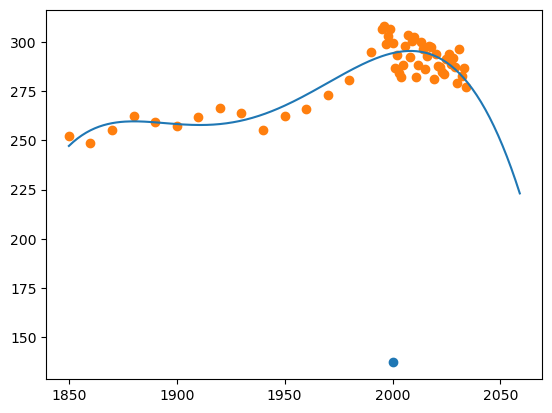

In [62]:
px = np.poly1d(np.polyfit(ds.t, ds.fCO2, 5))
sols = px[0] + px[1] * tt + px[2] * tt**2 + px[3] * tt**3 + px[4] * tt**4 + px[5] * tt**5
plt.plot(tt,sols)
plt.scatter(2000, ds.fCO2.isel(t = 0).values.tolist() - 2*noise_fco2)
plt.scatter(ds.t, ds.fCO2)

In [65]:
fco2 = pd.DataFrame(temp)
fco2.dropna()

,Lat,Lon,1850 fCO2,YOE Projected fCO2,YOE Actual fCO2 from polynomial,YOE
6,-64.5,0.5,288.244764,338.241304,338.619958,1986.0
7,-63.5,0.5,285.572746,330.767572,331.341920,1977.0
8,-62.5,0.5,285.766766,325.944099,326.413926,1972.0
9,-61.5,0.5,288.083677,326.232820,326.281032,1972.0
10,-60.5,0.5,288.393817,327.414942,327.576136,1969.0
...,...,...,...,...,...,...
44555,81.5,359.5,207.021215,285.273249,286.680649,2031.0
44556,82.5,359.5,218.552768,294.374399,295.093917,2040.0
44561,87.5,359.5,210.633289,275.489952,275.695006,2040.0
44562,88.5,359.5,209.904113,271.786205,272.389149,2034.0


In [35]:

sols[list(map(lambda m: m > PROJFCO2, sols.tolist())).index(True)]

269.5851376838982

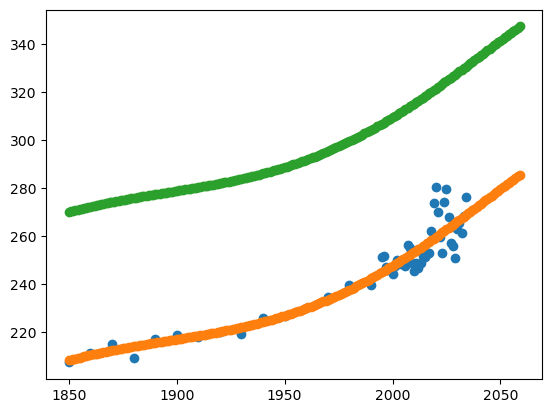

In [30]:
plt.scatter(ds.t, ds.fCO2)
plt.scatter(tt, sols)
plt.scatter(tt, sols + 2 * noise_fco2)

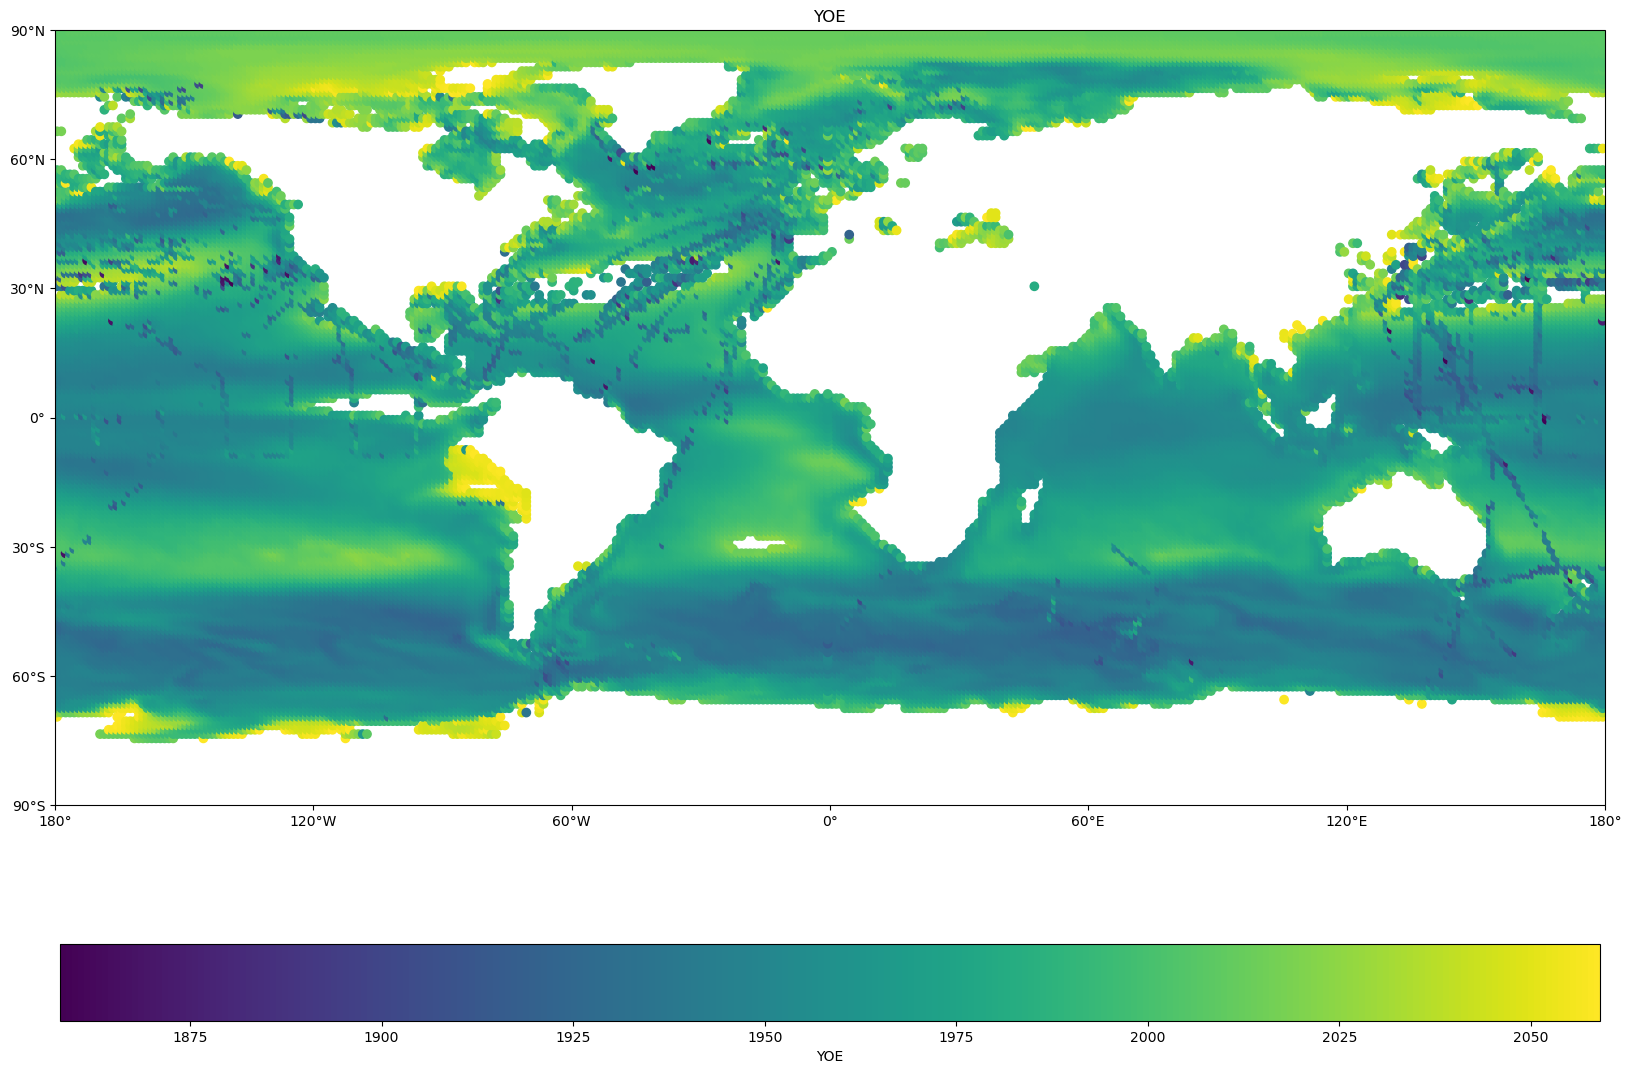

In [11]:
fig, ax = plt.subplots(figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})

# Plot of mean detrended pH
x,y = np.meshgrid(tmpdf['Lon'], tmpdf['Lat'])
yoe = ax.scatter(tmpdf['Lon'], tmpdf['Lat'], c= tmpdf['YOE'])
cbar0 = plt.colorbar(yoe, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar0.set_label('YOE')
ax.set_title('YOE')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)



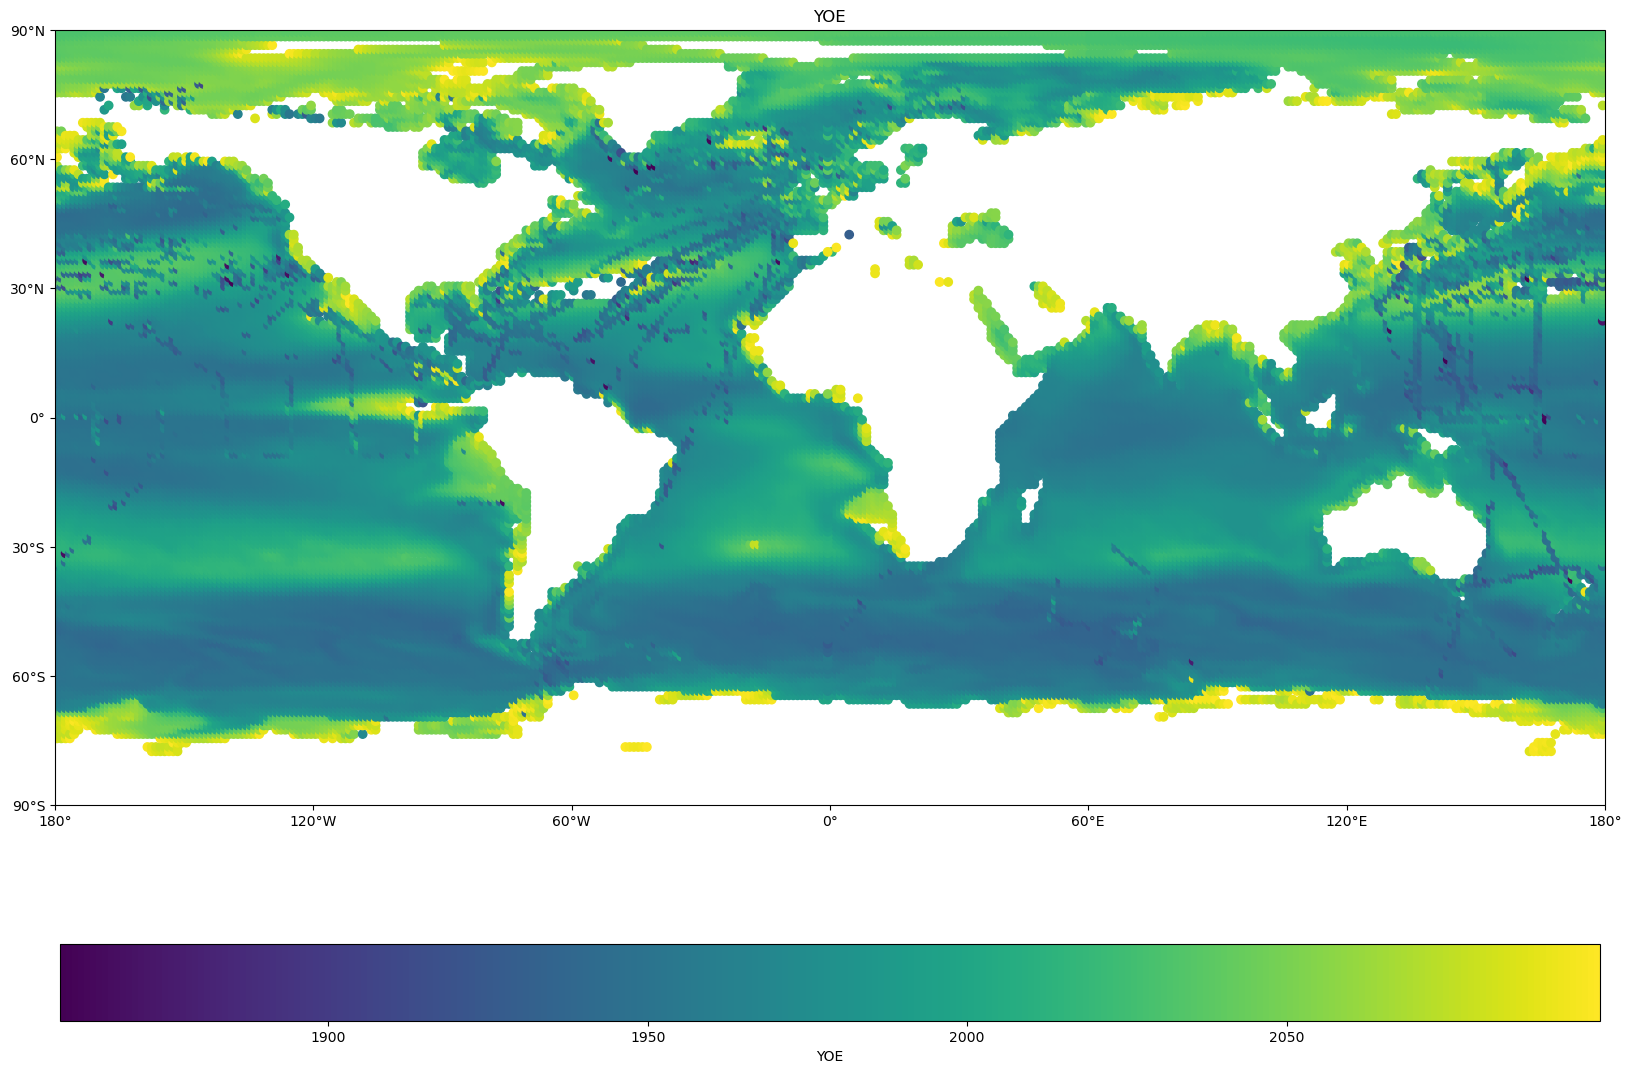

In [66]:
fig, ax = plt.subplots(figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})


yoe = ax.scatter(fco2['Lon'], fco2['Lat'], c= fco2['YOE'])
cbar0 = plt.colorbar(yoe, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar0.set_label('YOE')
ax.set_title('YOE')
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

AttributeError: 'GeoAxesSubplot' object has no attribute 'scatter3'

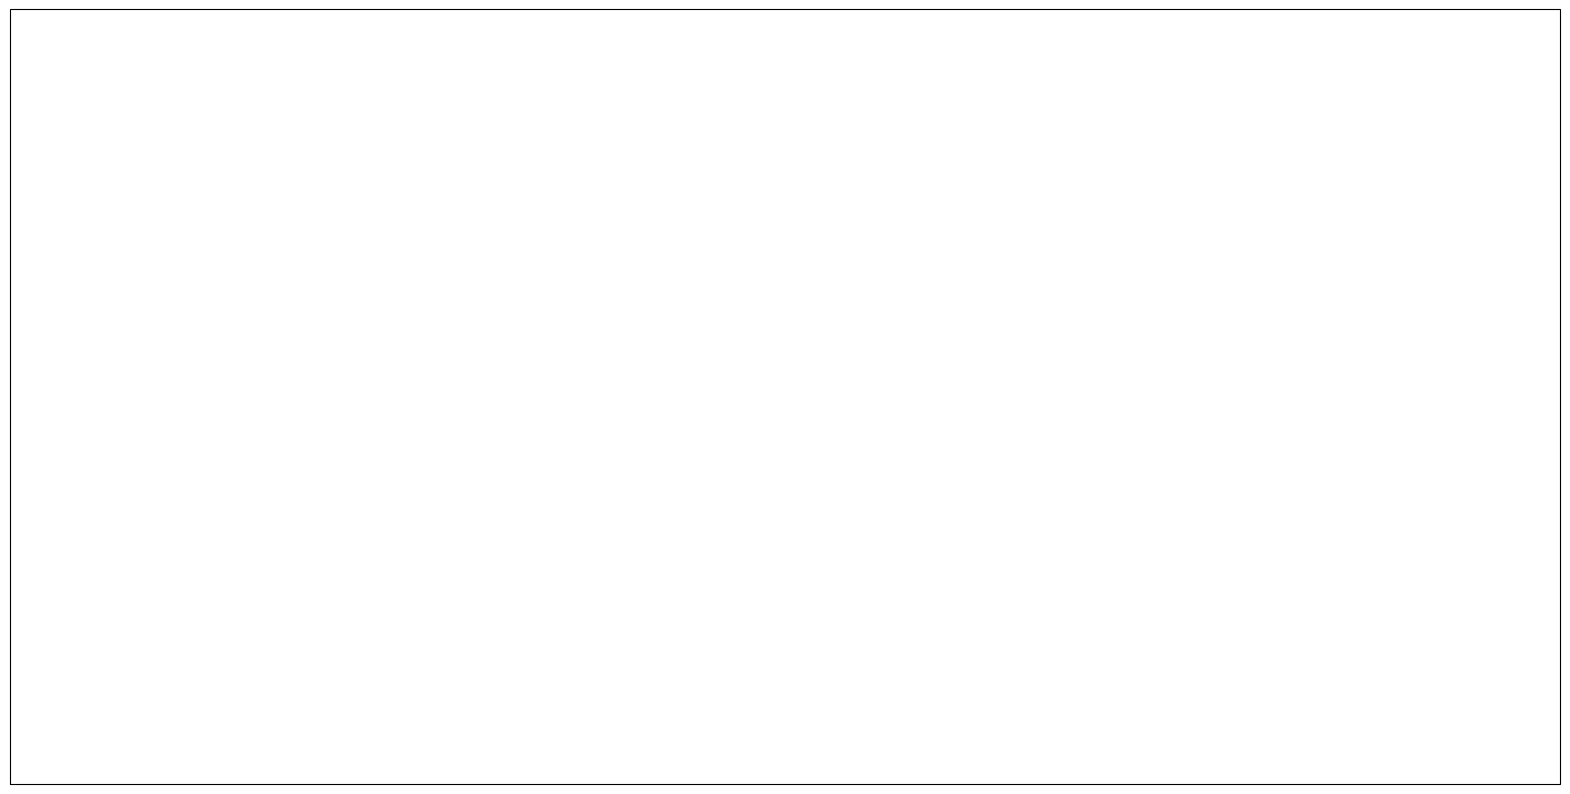

In [261]:
fig, axs = plt.subplots(figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})


# Plot of mean detrended pH
phmean = axs.(tmpdf['Lon'], tmpdf['Lat'], c = tmpdf['YOE'])
cbar0 = plt.colorbar(phmean, ax = axs, orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar0.set_label('YOE')
axs.set_title('Mean Detrended pH: 1995 - 2014')

# Conceptual background for 5th order polynomial

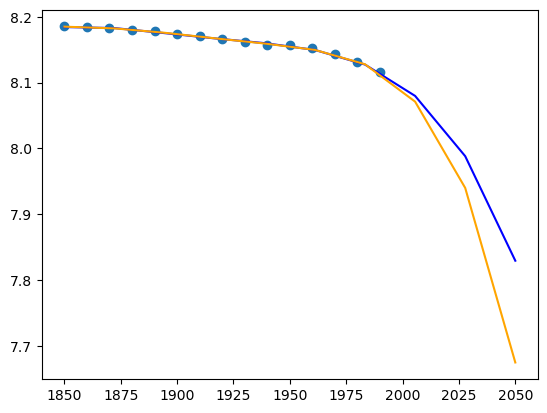

In [9]:
#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(ds.t, ds.ph, 1))
model2 = np.poly1d(np.polyfit(ds.t, ds.ph, 2))
model3 = np.poly1d(np.polyfit(ds.t, ds.ph, 6))
model4 = np.poly1d(np.polyfit(ds.t, ds.ph, 4))
model5 = np.poly1d(np.polyfit(ds.t, ds.ph, 5))

#create scatterplot
polyline = np.linspace(1850, 2050, 10)
plt.scatter(ds.t, ds.ph)

#add fitted polynomial lines to scatterplot 
# plt.plot(polyline, model1(polyline), color='green')
# plt.plot(polyline, model2(polyline), color='red')
# plt.plot(polyline, model3(polyline), color='purple')
plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='orange')
plt.show()

In [170]:
sols = px[0] + px[1] * tt + px[2] * tt**2 + px[3] * tt**3 + px[4] * tt**4 + px[5] * tt**5
# sols.tolist()

projph = ds.ph.isel(t = 0) - 2*noise
projph.values.tolist()

8.09155029296875

$$-6.24923762\times 10^{-12} + 5.91599898 \times 10^{-8} t -2.23971622 \times 10^{-4} t^2 + 4.23867155 \times 10^{-1} t^3 -4.00992934 \times 10^{2} t^4 + 1.51714079 \times 10^{5} t^5$$

In [99]:
ds = dd_.isel(y=0,x=0)
ds.ph.values

array([8.15155029, 8.15369701, 8.14995289, 8.15047359, 8.14445591,
       8.1413126 , 8.13619041, 8.13044071, 8.12630177, 8.12390518,
       8.12132835, 8.12170506, 8.11163425, 8.09913158, 8.08558464,
       8.08857059, 8.08578968, 8.0854454 , 8.08116436, 8.07936096,
       8.0760479 , 8.07128429, 8.07687092, 8.07105827, 8.07072258,
       8.06880093, 8.06893539, 8.06246471, 8.0600214 , 8.06254387,
       8.06320477, 8.0586338 , 8.05455303, 8.05037403, 8.05285549,
       8.05393314, 8.04901981, 8.04548645, 8.04492569, 8.03757763,
       8.03360367, 8.03115273, 8.03793144, 8.03356838, 8.03089428,
       8.03149509, 8.02083683, 8.02067852, 8.02049446, 8.01819324,
       8.01182842, 8.01317501, 8.00870323, 8.01059818, 8.00690365])

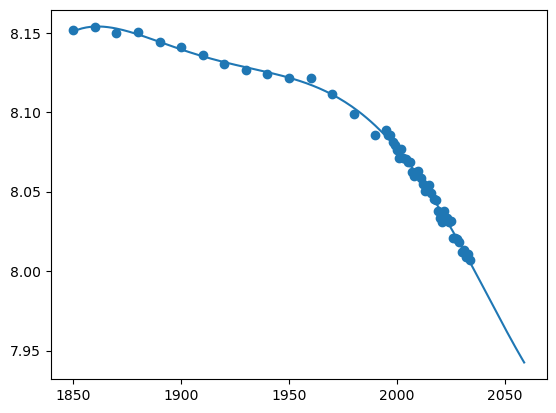

In [104]:
px = np.poly1d(np.polyfit(ds.t, ds.ph, 5))
t = np.arange(1850,2060,1)
fpx = px[0] + px[1] * t + px[2] * t**2 + px[3] * t**3 + px[4] * t**4 + px[5] * t**5 + px[6] * t**6 
plt.scatter(ds.t, ds.ph)
plt.plot(t, px(t))
# plt.plot(polyline, px(t) + noise)
# plt.plot(polyline, px(t) - noise)
# plt.plot(t, quintic_polynomial(px, t))

# plt.scatter(1983, 8.15527126312256 - noise)